**Write the names of all group members (max. 5 members)**:
- Oscar Romero, Alarcon
- Angus, Martin
- Konrad, Ochedzan
- Christopher, Yuan

When submitting your work, please follow closely the template below.

# Exercise 1

### Question 1.a

Check that $ S_t = s_0 \exp \left( \sigma W_t - \frac{1}{2} \sigma^2 t \right)$ solves the Black-Scholes SDE.

To check that $S_t = S_0 \exp \left( \sigma W_t - \frac{1}{2} \sigma^2 t \right)$ is a solution to the SDE

$$
dS_t = r S_t \, dt + \sigma S_t \, dW_t,
$$

we apply Itô’s formula to $ S_t $ and verify that it satisfies the given stochastic differential equation.

First we define $ S_t $ in terms of a function of $ W_t $ and $ t $:

   Let
   $$
   S_t = f(W_t, t) = S_0 \exp \left( \sigma W_t - \frac{1}{2} \sigma^2 t \right).
   $$

Next we compute the derivatives:

   - $$
     \frac{\partial f}{\partial W_t} = S_0 \cdot \sigma \exp \left( \sigma W_t - \frac{1}{2} \sigma^2 t \right) = \sigma f(W_t, t).
     $$

   - $$
     \frac{\partial f}{\partial t} = S_0 \cdot \left(-\frac{1}{2} \sigma^2 \right) \exp \left( \sigma W_t - \frac{1}{2} \sigma^2 t \right) = -\frac{1}{2} \sigma^2 f(W_t, t).
     $$

   - $$
     \frac{\partial^2 f}{\partial W_t^2} = S_0 \cdot \sigma^2 \exp \left( \sigma W_t - \frac{1}{2} \sigma^2 t \right) = \sigma^2 f(W_t, t).
     $$

This allows us to now apply Itô’s Formula to the function $ f(W_t, t) $, which gives:
   $$
   df(W_t, t) = \frac{\partial f}{\partial t} \, dt + \frac{\partial f}{\partial W_t} \, dW_t + \frac{1}{2} \frac{\partial^2 f}{\partial W_t^2} \, (dW_t)^2.
   $$

Substituting the derivatives computed above:
   $$
   dS_t = \left(-\frac{1}{2} \sigma^2 f(W_t, t) \right) dt + \left( \sigma f(W_t, t) \right) dW_t + \frac{1}{2} \left( \sigma^2 f(W_t, t) \right) dt.
   $$

Combine the terms involving $ dt $:
   $$
   dS_t = f(W_t, t) \left( -\frac{1}{2} \sigma^2 + \frac{1}{2} \sigma^2 \right) dt + \sigma f(W_t, t) \, dW_t.
   $$

   The terms involving $ \sigma^2 $ in the $ dt $-component cancel each other:
   $$
   dS_t = 0 \cdot dt + \sigma S_t \, dW_t = \sigma S_t \, dW_t.
   $$

Therefore the expression we obtained for $ dS_t $ is:
   $$
   dS_t = \sigma S_t \, dW_t,
   $$
   which matches the form of the SDE $ dS_t = r S_t \, dt + \sigma S_t \, dW_t $ with $ r = 0 $.

### Question 1.b - Generate dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp, sqrt, log
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d, Dropout
import torch.nn as nn
import scipy.stats as stats

from tqdm import tqdm
import torch.nn.init as init

In [2]:
train_size = 10**5
test_size = 10**4
N = 30
S_0 = 1
T = 30/365
sigma = 0.5

def generate_paths(size, S_0, N, T, sigma):
    dt = T / N
    drift = (-sigma**2 / 2) * dt
    diffusion = sigma * sqrt(dt)

    Z = np.random.normal(size=(size, N))
    increments = drift + diffusion * Z

    # We convert to cumulative log increments and then exponentiate for paths to optimize code using numpy cumsum
    log_paths = np.cumsum(increments, axis=1)
    log_paths = np.hstack((np.zeros((size, 1)), log_paths))

    paths = S_0 * np.exp(log_paths)
    return torch.tensor(paths, dtype=torch.float32)

# Generate train and test paths
train_paths = generate_paths(train_size, S_0, N, T, sigma)
test_paths = generate_paths(test_size, S_0, N, T, sigma)

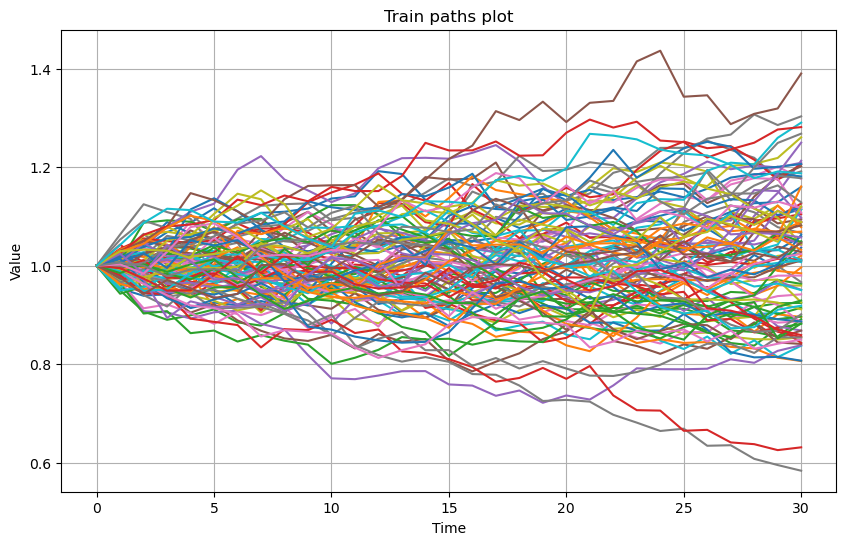

In [3]:
# Training paths plotting
plt.figure(figsize=(10, 6))
plt.plot(train_paths.detach().numpy()[:100].T)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Train paths plot')
plt.grid(True)
plt.show()

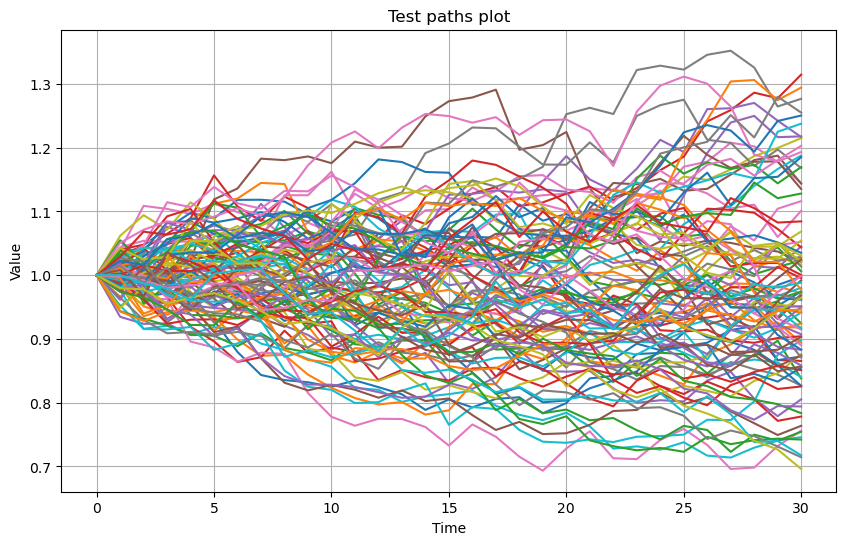

In [4]:
# Test paths plotting
plt.figure(figsize=(10, 6))
plt.plot(test_paths.detach().numpy()[:100].T)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Test paths plot')
plt.grid(True)

plt.show()

### Question 1.c - Model implementation

In [5]:
# Implement the deep hedging model

# Define the neural network at each time step t
class Hedge_time_t(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.network = nn.Sequential(
          nn.Linear(input_dim, 64), # Input: 1 -> 64
          nn.BatchNorm1d(64),
          nn.SiLU(),
          nn.Dropout(0.125),
          nn.Linear(64, 128), # Hidden 1: 64 -> 128
          nn.BatchNorm1d(128),
          nn.SiLU(),
          nn.Dropout(0.125),
          nn.Linear(128, 32), # Hidden 2: 128 -> 32
          nn.BatchNorm1d(32),
          nn.SiLU(),
          nn.Linear(32, 1)  # Output layer
      )

    def forward(self, x):
        return self.network(x)

# Class which contains the networks in each different time step t and calculates the hedging values for each
class DynamicHedgingModel(nn.Module):
    def __init__(self, n_timesteps):
        super().__init__()
        self.n_timesteps = n_timesteps

        # Separate networks for each time step
        self.hedge_networks = nn.ModuleList([
            Hedge_time_t(1) for _ in range(n_timesteps)
        ])

    def forward(self, x):
        x = x.float()
        batch_size = x.shape[0]
        hedge_values = torch.zeros((batch_size, self.n_timesteps), dtype=x.dtype)

        # Log returns for each time step
        log_prices = torch.log(x)

        for t in range(self.n_timesteps):
            # Reshape log price at time t to (batch_size, 1)
            log_price_t = log_prices[:, t].unsqueeze(1)
            #  Calculate the hedging values. Squeeze to change the output shape from (B, 1) to (B,) where B=number of batches
            hedge_values[:, t] = self.hedge_networks[t](log_price_t).squeeze()

        return hedge_values

# Initialize model
dhmodel_ex1 = DynamicHedgingModel(n_timesteps=N)

### Question 1.d - Model training

In [6]:
# Implement the payoff function of a call option
def call_payoff(S, K=1.0):
    return max(0, S[-1]-K)

# Payoffs for observations in test set
train_payoffs = torch.zeros(train_size)#, dtype = torch.float32)
for i in range(train_size):
    train_payoffs[i] = call_payoff(train_paths[i], K=1.0)
# Convert input and output (train) into a tensor dataset for the DataLoader
train_dataset = TensorDataset(train_paths, train_payoffs)

# Payoffs for observations in test set
test_payoffs = torch.zeros(test_size, dtype = torch.float32)
for i in range(test_size):
    test_payoffs[i] = call_payoff(test_paths[i], K=1.0)

In [7]:
# Implement a function that returns the Black-Scholes price of a call option with given strike and maturity
def BS_Vt(S, t, K, r, T, sigma):
    d_plus = 1/(sigma*sqrt(T-t)) * (log(S[t]/K) + (r + sigma ** 2 / 2) * (T-t))
    d_neg = d_plus - sigma*sqrt(T-t)

    call_price = stats.norm.cdf(d_plus) * S[t] - stats.norm.cdf(d_neg)*K*exp(-r*(T-t))

    return call_price

# Definition of loss function (2) given in the assignment for a batch tensor of shape (B,m)
def DH_loss(g, p, H, S):
    S_diff = torch.diff(S, dim=1).float()
    hedge_gain = g - p - torch.sum(H * S_diff, dim=1)
    loss = torch.mean(hedge_gain**2)

    return loss

100%|██████████| 10/10 [09:15<00:00, 55.58s/it, loss=0.124]


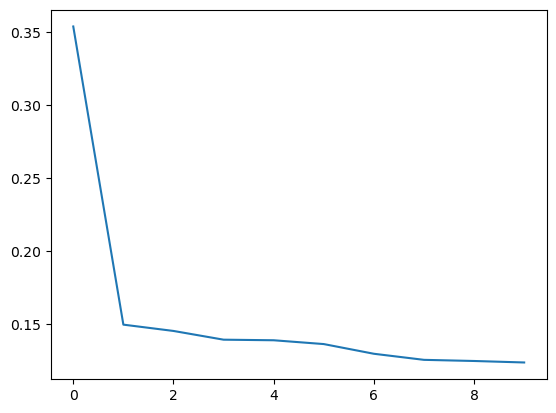

In [8]:
# Train the model

# Training hyperparameters
n_epochs = 10
lr = 0.01
batch_size = 100

# Create a batch loader from the dataset
loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

optimizer = torch.optim.Adam(dhmodel_ex1.parameters(), lr=lr)

# Instantiate a scheduler to decrease the learning rate during training according to a pre-defined rule
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.2, total_iters=n_epochs)

# Calculate call price, which can be modified if further different initial conditions
# We can use whatever path as they all have same initial value
V0 = BS_Vt(train_paths[0, :], 0, 1, 0.0, T, sigma)

# Loading bar for training loop
training_loop = tqdm(range(n_epochs))
epoch_losses = []

for epoch in training_loop:
    batch_losses = []
    for stock_paths, payoffs in loader:
        optimizer.zero_grad()

        # Get hedge vaues from hedging model
        hedge_ratios = dhmodel_ex1(stock_paths)#.to(torch.float32))
        # Calculate hedging loss
        loss = DH_loss(payoffs, V0, hedge_ratios, stock_paths)

        # Backpropagation and optimize
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

    # Aggregate epoch loss as sum across batches
    epoch_loss = np.sum(batch_losses)
    epoch_losses.append(epoch_loss)

    # Displaying progress
    training_loop.set_postfix(loss=epoch_loss)

    # Iterate learning rate scheduler
    scheduler.step()

plt.plot(epoch_losses, label='Training loss')
plt.show()

### Question 1.e - Model evaluation

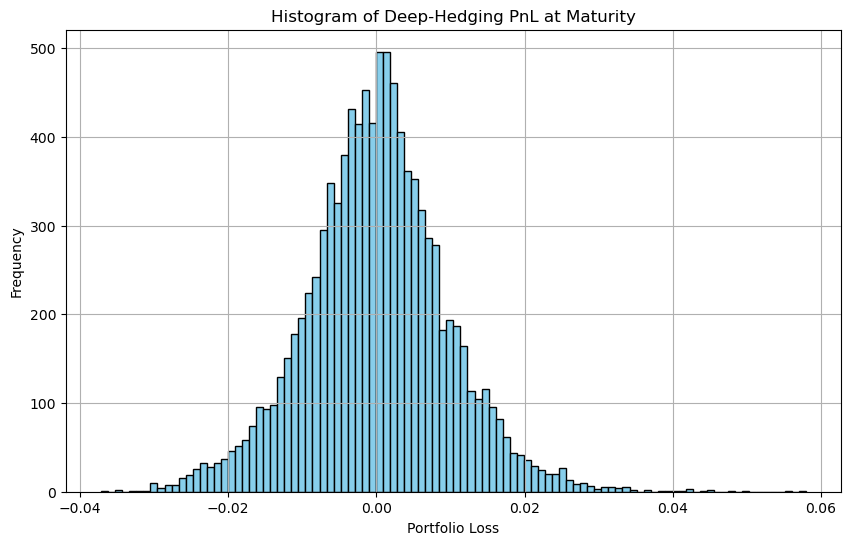

Mean of deep-hedged portfolio PnL: 4.511313818511553e-05
Standard deviation of deep-hedged portfolio PnL: 0.009546210058033466


In [9]:
# Evaluate the losses incurred from hedging on the test set
def hedge_pnl(g, p, H, S):
    S_diff = torch.diff(S, dim=1).float()
    losses = g - p - torch.sum(H * S_diff, dim=1)
    return losses

# Hedging ratios of deep hedging portfolio
test_hedge_ratios = dhmodel_ex1(test_paths)
# Hedging losses
losses = hedge_pnl(test_payoffs, V0, test_hedge_ratios, test_paths)

# Statistics
loss_mean = losses.mean().item()
loss_std = losses.std().item()


# Plot histogram of hedging losses as a single dataset
plt.figure(figsize=(10, 6))
losses_np = losses.detach().flatten().numpy()
plt.hist(losses_np, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Portfolio Loss')
plt.ylabel('Frequency')
plt.title('Histogram of Deep-Hedging PnL at Maturity')
plt.grid(True)
plt.show()

print(f"Mean of deep-hedged portfolio PnL: {loss_mean}")
print(f"Standard deviation of deep-hedged portfolio PnL: {loss_std}")

# Exercise 2

### Question 2.a - Compute analytical solution

Here we show a step-by-step derivation of the analytical hedging strategy:

\begin{align*}
H^{\text{BS}}_t(s) & = \frac{\partial C(s, t)}{\partial s}
\end{align*}

To start, we know that $C(s, t) = \Phi(d_+) s - \Phi(d_-) K e^{-r(T - t)}$, where

$$ d_+ = \frac{\log\left(\frac{s}{K}\right) + \left(r + \frac{1}{2} \sigma^2\right) (T-t)}{\sigma \sqrt{T-t}}, \; d_- = d_+ - \sigma \sqrt{T-t} $$

Using the product rule and the chain rule,

$$
\frac{\partial C(s, t)}{\partial s} = \Phi(d_+) + \frac{\partial \Phi(d_+)}{\partial s}\left(\frac{\partial d_+}{\partial s}\right) s - \frac{\partial \Phi(d_-)}{\partial s}\left(\frac{\partial d_-}{\partial s}\right) K e^{-r(T - t)}
$$

Using the form of $d_-$ above, it is clear that $\frac{\partial d_+}{\partial s} = \frac{\partial d_-}{\partial s}$, and therefore
$$
\frac{\partial C(s, t)}{\partial s} = \Phi(d_+) + \frac{\partial d_+}{\partial s}\left(\frac{\partial \Phi(d_+)}{\partial s} s - \frac{\partial \Phi(d_-)}{\partial s} K e^{-r(T - t)}\right)
$$
**We aim to show that $\left(\frac{\partial \Phi(d_+)}{\partial s} s - \frac{\partial \Phi(d_-)}{\partial s} K e^{-r(T - t)}\right)$ = 0.**

First, noting from the definition of the Gaussian CDF, $\frac{\partial \Phi(x)}{\partial x} = \frac{1}{\sqrt{2 \pi}} \exp(\frac{-x^2}{2})$, we have

$$
\begin{aligned}
  \frac{\partial \Phi(d_+)}{\partial s} s - \frac{\partial \Phi(d_-)}{\partial s} K e^{-r(T - t)} &= \frac{1}{\sqrt{2\pi}}\left[\exp\left(\frac{-d_+^2}{2}\right)s - Ke^{-r(T - t)}\exp\left(\frac{-d_+^2 + 2d_+\sigma\sqrt{T-t} - \sigma^2(T- t)}{2}\right)\right] \\
  &= \frac{\exp\left(\frac{-d_+^2}{2}\right)}{\sqrt{2\pi}}\left[s - Ke^{-r(T - t)}\exp\left(\frac{2d_+\sigma\sqrt{T-t} - \sigma^2(T- t)}{2}\right)\right]
\end{aligned}
$$

By the definition of $d_+$, $d_+\sigma\sqrt{T-t} = \log\left(\frac{s}{K}\right) + \left(r + \frac{1}{2} \sigma^2\right) (T-t)$, hence

$$
\begin{aligned}
  \frac{\partial \Phi(d_+)}{\partial s} s - \frac{\partial \Phi(d_-)}{\partial s} K e^{-r(T - t)} &= \frac{\exp\left(\frac{-d_+^2}{2}\right)}{\sqrt{2\pi}}\left[s - Ke^{-r(T - t)}\exp\left(\log\left(\frac{s}{K}\right) + r(T-t)\right)\right] \\
  &= \frac{\exp\left(\frac{-d_+^2}{2}\right)}{\sqrt{2\pi}} \left[s - K\exp\left(\log\left(\frac{s}{K}\right)\right)\right] \\
  &= 0
\end{aligned}
$$

as desired. This means that

$$
  \frac{\partial C(s, t)}{\partial s} = \Phi(d_+) + \frac{\partial d_+}{\partial s} ( 0 )
$$

so,

$$
H^{\text{BS}}_t(s) = \frac{\partial C(s, t)}{\partial s} = \Phi(d_+)
$$


### Question 2.b - Analytical solution evaluation

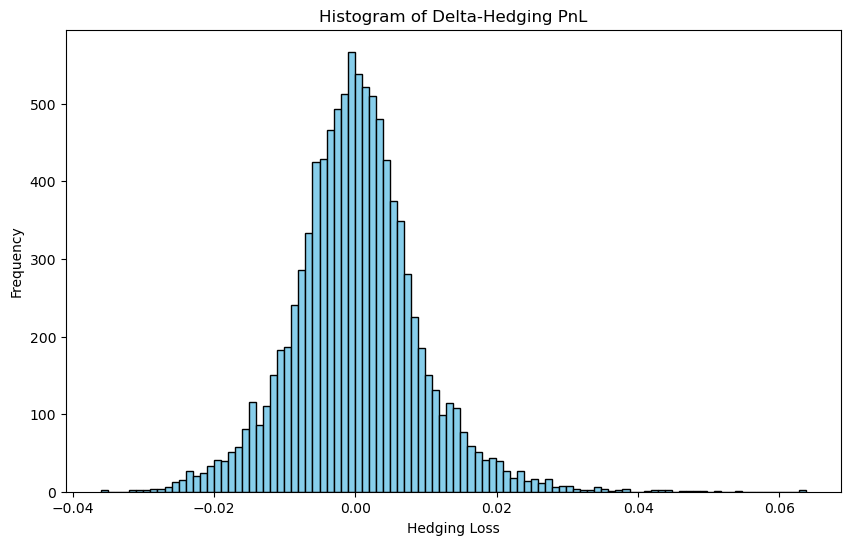

Mean of (analytically) delta-hedged portfolio PnL: 7.623395126925664e-05
Standard deviation of (analytically) delta-hedged portfolio PnL: 0.008895542365347592


In [10]:
# Importing normal random variable class from PyTorch
from torch.distributions import Normal
normal_dist = Normal(loc=0.0, scale=1.0)

def BS_delta(S, K, T, t, sigma):
    if T - t <= 0:
        return 0

    d_plus = (torch.log(torch.div(S, K)) + (0.5 * sigma ** 2) * (T - t)) / (sigma * sqrt(T - t))
    delta = normal_dist.cdf(d_plus)
    return delta


def delta_hedge(S_prices, N, K=1, T=30/365, sigma=0.5):
    H_analytic = np.zeros((S_prices.shape[0], N))

    for i in range(N):
        S = S_prices[:, i]
        deltas = BS_delta(S, 1, T, i / 365, sigma)
        H_analytic[:, i] = deltas

    return torch.from_numpy(H_analytic)

# Hedge values from hedging model
analytic_H = delta_hedge(test_paths, 30, 1, T, sigma)
# Hedging losses
losses = hedge_pnl(test_payoffs, V0, analytic_H, test_paths)

plt.figure(figsize=(10, 6))
plt.hist(losses.detach().flatten().numpy(), bins=100, color='skyblue', edgecolor='black')
plt.title("Histogram of Delta-Hedging PnL")
plt.xlabel("Hedging Loss")
plt.ylabel("Frequency")
plt.show()

print(f"Mean of (analytically) delta-hedged portfolio PnL: {torch.mean(losses)}")
print(f"Standard deviation of (analytically) delta-hedged portfolio PnL: {torch.std(losses)}")

We note that even though the analytically derived delta-hedging strategy should theoretically offer a perfect hedging strategy, this is only in the case when the delta is calculated at arbitrarily close time steps. Since we are calculating the delta at a discrete set of times, we are only approximately hedging the asset by rebalancing our portfolio a finite number of times. This explains the distribution around 0 we see in the PnL of our analytical hedging portfolios.

### Question 2.c - Hedging losses comparison

Overall the deep-hedging model performs admirably, with the distribution of deep-hedged portfolio PnLs sharply peaked around $0$ as desired. Compared to the distribution of the analytically hedged portfolios, we were able to achieve an smaller average PnL (in magnitude) indicating on average a superior hedging strategy. Additionally, in regards to standard deviation, both models yield tightly grouped distributions, with standard deviations in the neighbourhood of $10^{-2}$, although the analytical solution did provide a marginally smaller standard deviation against our deep-hedging network. This differnce is minor, however, and we believe could be nullified by increasing the number of training epochs. Due to the dropout layers implemented in our network, overfitting will not be as acute as otherwise, and so increasing the epochs should boost performance, although this consumes a lot of compute time.

### Question 2.d - Learned strategy comparison

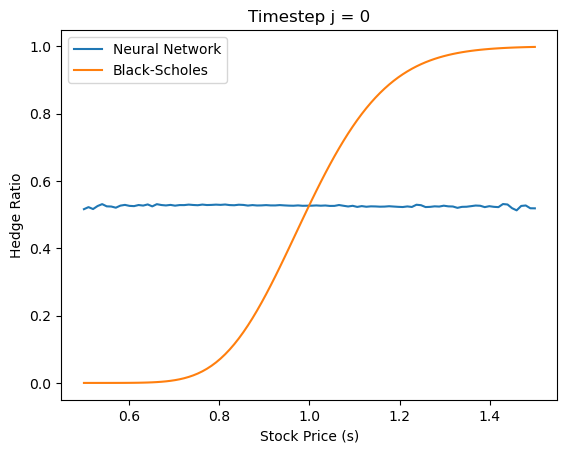

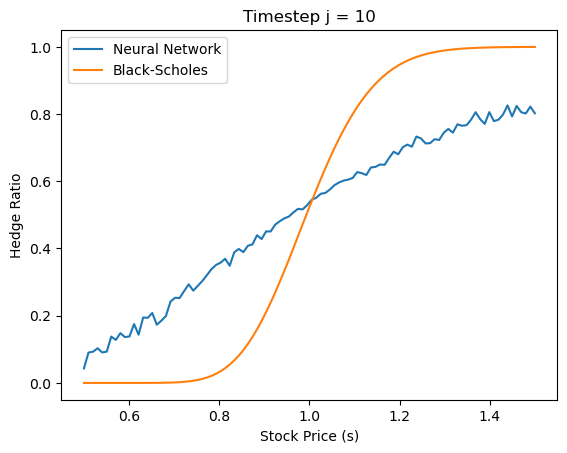

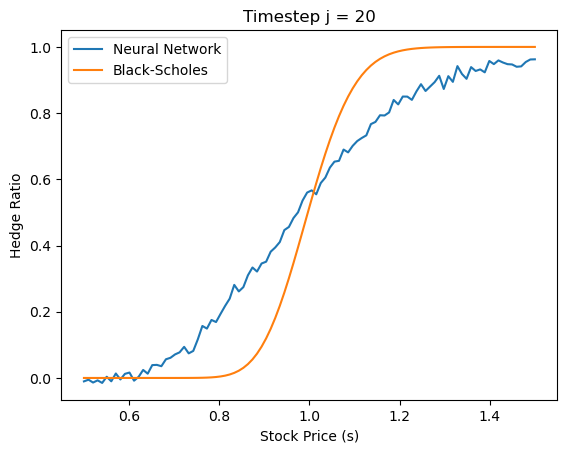

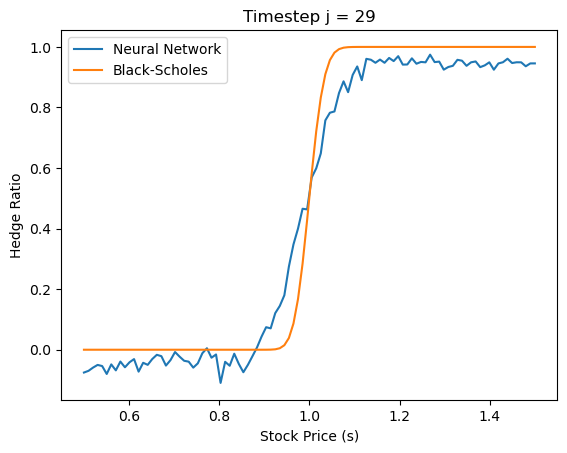

In [11]:
# Plot both the neural network strategies and the analytical hedging strategies
T=30/365
s_range = np.linspace(0.5, 1.5, 100)
s_torch = torch.tensor(s_range, dtype = torch.float32)

timesteps = [0, 10, 20, 29]

for j in timesteps:

    # Neural network predictions
    nn_predictions = dhmodel_ex1.hedge_networks[j](torch.log(s_torch).unsqueeze(1)).squeeze().detach().numpy()
    # Black-Scholes delta
    bs_delta = BS_delta(s_torch, 1, T, j/365, sigma=0.5)

    # Plotting
    plt.figure()
    plt.plot(s_range, nn_predictions, label="Neural Network")
    plt.plot(s_range, bs_delta, label="Black-Scholes")
    plt.xlabel("Stock Price (s)")
    plt.ylabel("Hedge Ratio")
    plt.title(f"Timestep j = {j}")
    plt.legend()
    plt.show()

The curve generated by the neural network seems to converge to the Black-Scholes solution as $t_j \to T$ (or as $j$ approaches $30$). This is likely an artifact of the training process since, due to the nature of the geometric brownian motion paths, the model has fewer extreme observations (stock prices away from $1.0$) at earlier time steps. This means that the networks related to these times have less data to which they can fit the BS curve. Moreover, in practice, this has little effect on the performance of the model since these values are unlikely to be seen in runtime. An additional explanation for the "underfitting" seen in the earlier cross sections is the nature of the loss function where the hedging ratios are multiplied by the forward difference in stock price. Since in the case of GBM we on average expect this difference to be greater for larger $t_j$, this could mean that small errors in the estimated $H_{t_j}$ for small $t_j$ would be penalized less than for larger $t_j$.

Finally, to comment on the overall shape of the NN-approximated curve, we highlight two key features: 1) the jagged-nature of the curve, and 2) the general shape. In particular, the "noisiness" is caused by the dropout we have applied between layers, while the latter is caused by the SiLU activation function, explaining the vaguely sigmoid curve seen at each time step.

# Exercise 3

### Question 3.a - Model implementation

In [ ]:
# Implement the new deep hedging model

In [12]:
class DeepHedgingModelEx3(nn.Module):
    def __init__(self, input_size):
        super(DeepHedgingModelEx3, self).__init__()
        # Define the feedforward neural network architecture
        self.network = nn.Sequential(
            nn.Linear(input_size, 32), # Input: 1 -> 32
            nn.BatchNorm1d(32),
            nn.SiLU(),
            nn.Linear(32, 64), # Hidden 1: 32 -> 64
            nn.BatchNorm1d(64),
            nn.SiLU(),
            nn.Linear(64, 32), # Hidden 2: 64 -> 32
            nn.BatchNorm1d(32),
            nn.SiLU(),
            nn.Linear(32, 1) # Output
        )

    def forward(self, time_to_maturity, log_price):
        # Concatenate inputs for a single input tensor
        inputs = torch.cat((time_to_maturity.unsqueeze(1), log_price.unsqueeze(1)), dim=1)
        return self.network(inputs)

### Question 3.b - Model training

In [ ]:
# Train the new deep hedging model

100%|██████████| 8/8 [04:03<00:00, 30.43s/it, loss=0.132]


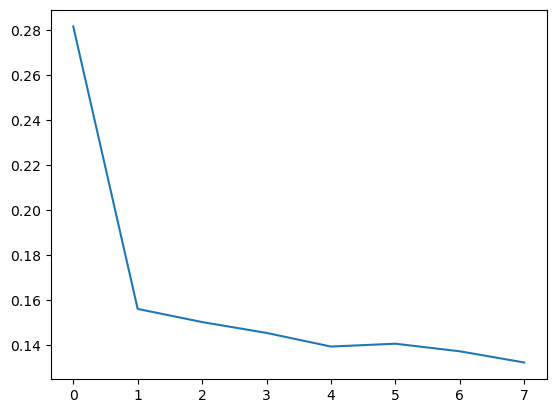

In [13]:
# Hyperparameters
input_size = 2  # T-tj and log(Stj) as inputs
batch_size = 100
epochs = 8
learning_rate = 0.01

# Create model instance
dhmodel_ex3 = DeepHedgingModelEx3(input_size)

# Define loss and optimizer
optimizer = torch.optim.Adam(dhmodel_ex3.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=epochs)

j_values = torch.arange(31, dtype=torch.float32)

sqrtTmt = torch.sqrt((30 - j_values) / 365)
sqrtTmt_train = sqrtTmt.repeat(train_size, 1)

logS_train = torch.log(train_paths)

train_dataset = TensorDataset(sqrtTmt_train, logS_train, train_payoffs)

loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
epoch_losses = []
training_loop = tqdm(range(epochs))
# Train the model
for epoch in training_loop:
    batch_losses = []
    for sqrtTmt_batch, logS_batch, payoffs in loader:
      optimizer.zero_grad()
      Ht_list = torch.zeros(batch_size, 30)  # Pre-allocate tensor with shape (64, 30)

      for time in range(30):  # Iterate over the time dimension
          hedge_ratios = dhmodel_ex3(sqrtTmt_batch[:, time], logS_batch[:, time])
          Ht_list[:, time] = hedge_ratios.squeeze()  # Assign hedge ratios to the correct column

      loss = DH_loss(payoffs, V0, Ht_list, torch.exp(logS_batch))
      loss.backward()
      optimizer.step()

      batch_losses.append(loss.item())
    epoch_loss = np.sum(batch_losses)
    epoch_losses.append(epoch_loss)

    training_loop.set_postfix(loss=epoch_loss)

    scheduler.step()

plt.plot(epoch_losses, label='Training loss')
plt.show()

### Question 3.c - Model evaluation

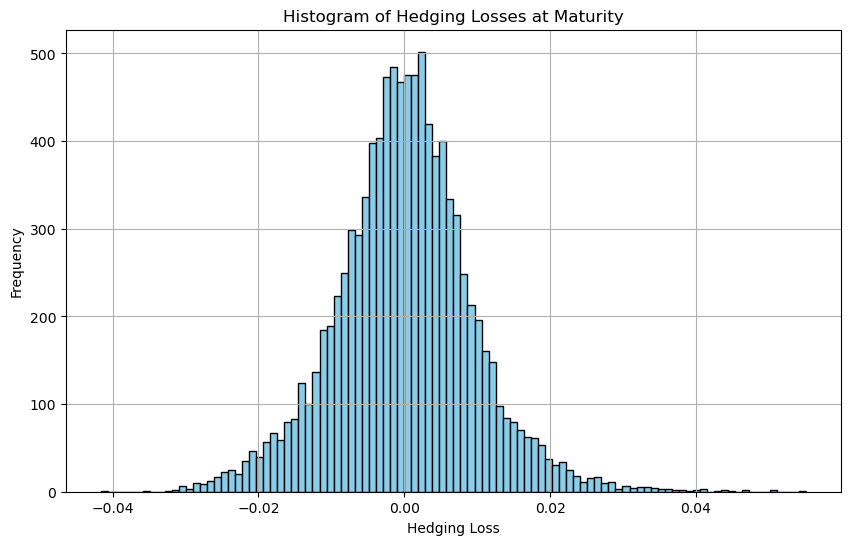

Mean of Hedging Losses: 1.8456026737112552e-05
Standard Deviation of Hedging Losses: 0.00943890679627657


In [14]:
sqrtTmt_test = sqrtTmt.repeat(test_size, 1)

logS_test = torch.log(test_paths)
Ht_list = torch.zeros(test_size, 30)

for j in range(30):
  hedge_ratios = dhmodel_ex3(sqrtTmt_test[:, j], logS_test[:, j])
  Ht_list[:, j] = hedge_ratios.squeeze()  # Assign hedge ratios to the correct column

losses = hedge_pnl(test_payoffs, V0, Ht_list, test_paths)

loss_mean = losses.mean().item()
loss_std = losses.std().item()


# Plot histogram of hedging losses as a single dataset
plt.figure(figsize=(10, 6))
losses_np = losses.detach().flatten().numpy()
plt.hist(losses_np, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Hedging Loss')
plt.ylabel('Frequency')
plt.title('Histogram of Hedging Losses at Maturity')
plt.grid(True)
plt.show()

print(f"Mean of Hedging Losses: {loss_mean}")
print(f"Standard Deviation of Hedging Losses: {loss_std}")

### Question 3.d - Model comparison

In [17]:
# Run time comparison
import time

dhnn1_times = []
dhnn2_times = []

runs = 10
sim_size = 10000

for _ in range(runs):
    sim_paths = generate_paths(sim_size, S_0, N, T, sigma)

    # Timing dhmodel_ex1 (joint networks)
    dhnn1_t0 = time.time()
    hedge = dhmodel_ex1(sim_paths)
    dhnn1_t1 = time.time()
    dhnn1_times.append(dhnn1_t1 - dhnn1_t0)

    # Timing dhmodel_ex3 (integrated time input)
    dhnn2_t0 = time.time()
    log_paths = torch.log(sim_paths)
    sqrtTmt_sim = sqrtTmt.repeat(sim_size, 1)

    Ht_list = torch.zeros(test_size, 30)

    for j in range(30):
        hedge_ratios = dhmodel_ex3(sqrtTmt_sim[:, j], log_paths[:, j])
        Ht_list[:, j] = hedge_ratios.squeeze()  # Assign hedge ratios to the correct column

    dhnn2_t1 = time.time()
    dhnn2_times.append(dhnn2_t1 - dhnn2_t0)

print(f"Average compute time for DH model 1 (joint networks) across 10 simulations: {np.mean(dhnn1_times):.4f}")
print(f"Average compute time for DH model 2 (integrated time) across 10 simulations: {np.mean(dhnn2_times):.4f}")

Average compute time for DH model 1 (joint networks) across 10 simulations: 0.4178
Average compute time for DH model 2 (integrated time) across 10 simulations: 0.1048


In [18]:
# Computing the total number of parameters for each network
dhnn1_weights = 64 + 64*128 + 128*32 + 32
dhnn1_biases = 64 + 128 + 32 + 1
dhnn1_total = 30 * (dhnn1_weights + dhnn1_biases) # Same architecture is repeated for 30 time steps

dhnn2_weights = 32 + 32*64 + 64*32 + 32
dhnn2_biases = 32 + 64 + 32 + 1
dhnn2_total = 1 * (dhnn2_weights + dhnn2_biases)

print(f"Number of parameters in model 1: {dhnn1_total}")
print(f"Number of parameters in model 2: {dhnn2_total}")

Number of parameters in model 1: 378270
Number of parameters in model 2: 4289


| | Mean    | Standard deviation | Time | Parameters |
| --- | -------- | ------- | --- | --- |
| Model 1 | 4.51e-05  | 0.0095    | 0.4178s | 378270 |
| Model 2 | 1.85e-05 | 0.0094   | 0.1048s | 4289 |

Table: Mean and standard deviation taken with respect to PnL incurred on test set from hedging portfolio at maturity. Time averaged across 10 simulations, with 10,000 sample paths.

Comparing the models we see that across the baord Model 2, with time integrated as an input, outperforms our original Model 1, constructed from 30 joint networks. This ultimately has to do with the fact that the first architecture is severely overparameterized for the task at hand. This is because the first design relies on 30 distinct networks all of which must be trained to learn a similar curve (as seen in question 2d), as compared to the second model which incorporates time directly into the relationship. In order to make this stack of networks learn a sufficiently powerful representation we must increase the complexity of the architecture, adding more parameters as well as dropout to avoid overfitting. This in turn increases the noise in our predictions, which we combat by increasing the number of training epochs. 

All of these factors combine to make our second model by far the more simple of the two, without compromising performance. This indicates that the architecture of Model 2 is better adapted for deep hedging.